In [1]:
import numpy as np
import scipy.linalg
import scipy.io
import itertools
import matplotlib.pyplot as plt

from qiskit.visualization import *
from qiskit.extensions import UnitaryGate

# custom utility functions
from util import *
from qetu import *
from tfim import *
from fermi_hubbard import *
from wmi_backend import *

### Single Trotter step

In [2]:
nqubits = 2
nsysqubits = 2*nqubits
μ = 0
u = 3
t = 2
delta_t = 1

#### Construct controlled Trotter

In [3]:
def add_zcz_wmi(circuit, control, target):
    """
    Add a zero-controlled z-gate decomposed into the gate set of the WMI
    """
    circuit.x(control)
    circuit.sx(target)
    circuit.rz(np.pi/2, target)
    circuit.sx(target)
    circuit.cp(np.pi, control, target)
    circuit.sx(target)
    circuit.rz(np.pi/2, target)
    circuit.sx(target)
    circuit.x(control)

def add_zcx_wmi(circuit, control, target):
    """
    Add a zero-controlled x-gate decomposed into the gate set of the WMI
    """
    circuit.x(control)
    circuit.sx(target)
    circuit.rz(np.pi, target)
    circuit.sx(target)
    circuit.cp(np.pi, control, target)
    circuit.sx(target)
    circuit.rz(np.pi, target)
    circuit.sx(target)
    circuit.x(control)

def add_rzz(circuit, theta, control, target):
    """
    Add a RZZ gate decomposed into the gate set of the WMI
    """
    circuit.sx(target)
    circuit.rz(np.pi/2, target)
    circuit.sx(target)
    circuit.cp(np.pi, control, target)
    circuit.sx(target)
    circuit.rz(np.pi/2, target)
    circuit.sx(target)
    circuit.rz(theta, target)
    circuit.sx(target)
    circuit.rz(np.pi/2, target)
    circuit.sx(target)
    circuit.cp(np.pi, control, target)
    circuit.sx(target)
    circuit.rz(np.pi/2, target)
    circuit.sx(target)

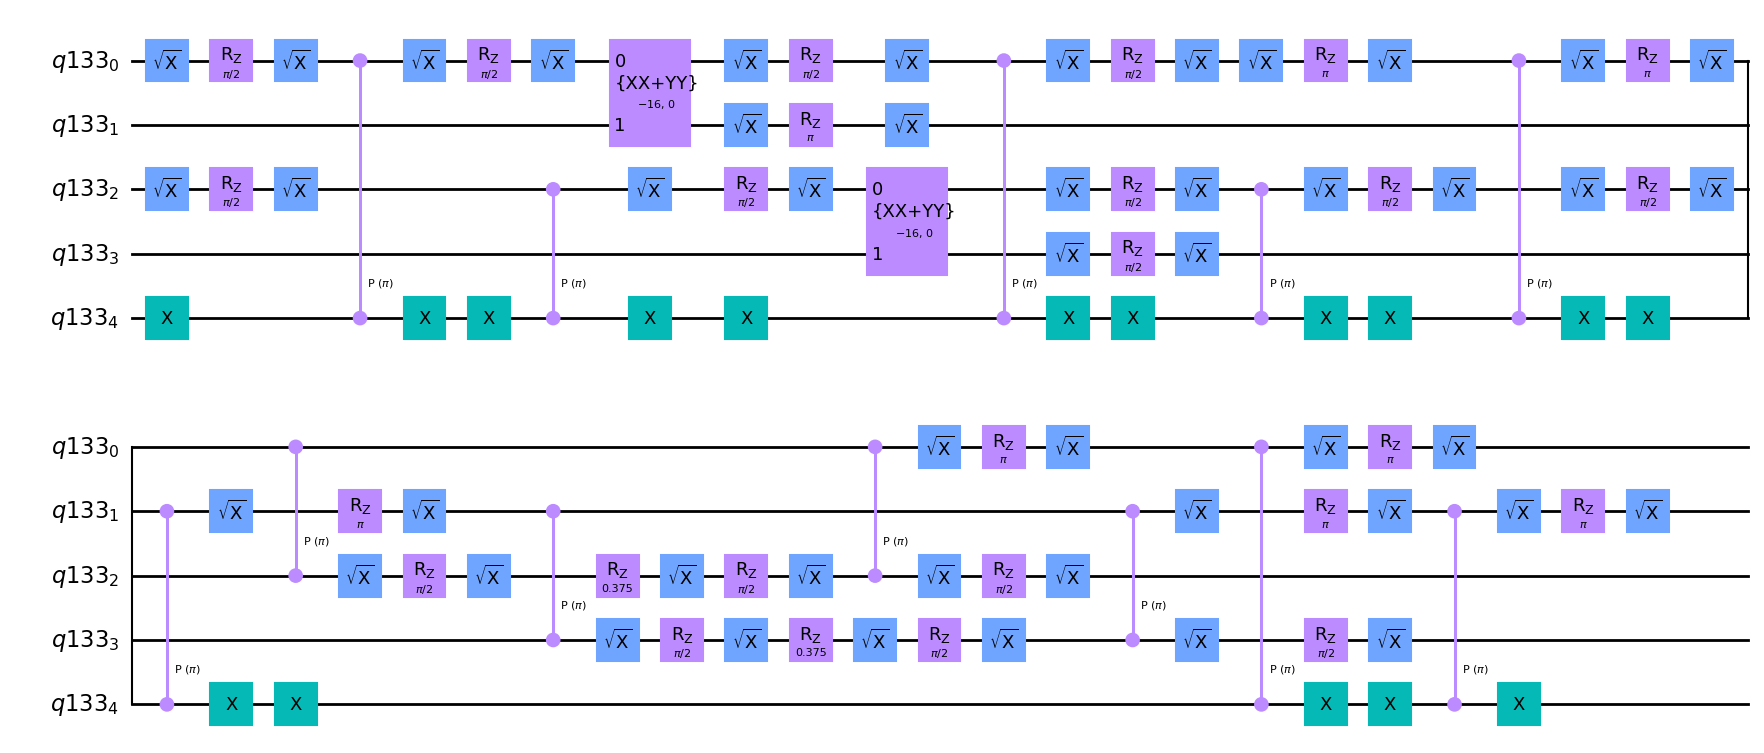

In [20]:
from qiskit.circuit.library import PhaseGate
from qiskit.quantum_info.operators import Operator

q = QuantumRegister(5)
qc_trotter = QuantumCircuit(q)

# calculate theta for XXPlusYY gate
theta = -8*t
beta = 0
#qc_trotter.barrier(q)
add_zcz_wmi(qc_trotter, 4, 0)
add_zcz_wmi(qc_trotter, 4, 2)
#qc_trotter.barrier(q)
qc_trotter.append(XXPlusYYGate(theta, beta), [0, 1])
qc_trotter.append(XXPlusYYGate(theta, beta), [2, 3])
#qc_trotter.barrier(q)
add_zcz_wmi(qc_trotter, 4, 0)
add_zcz_wmi(qc_trotter, 4, 2)
#qc_trotter.barrier(q)
#qc_trotter.barrier(q)
add_zcx_wmi(qc_trotter, 4, 0)
add_zcx_wmi(qc_trotter, 4, 1)
#qc_trotter.barrier(q)
θ = 1/4 * delta_t * u / nqubits

# RZ(lam) & P(-2*lam)
# RZ(lam)
#qc_trotter.rzz(θ, q[0], q[2])
#qc_trotter.rzz(θ, q[1], q[3])
add_rzz(qc_trotter, θ, q[0], q[2])
add_rzz(qc_trotter, θ, q[1], q[3])
#qc_trotter.barrier(q)
add_zcx_wmi(qc_trotter, 4, 0)
add_zcx_wmi(qc_trotter, 4, 1)

qc_trotter.draw("mpl")

In [21]:
backend = FakeWMI()
noise_model = NoiseModel.from_backend(backend)
noise_model

<NoiseModel on ['xx_plus_yy', 'measure', 'y', 'x', 'sx', 'iswap', 'cp']>

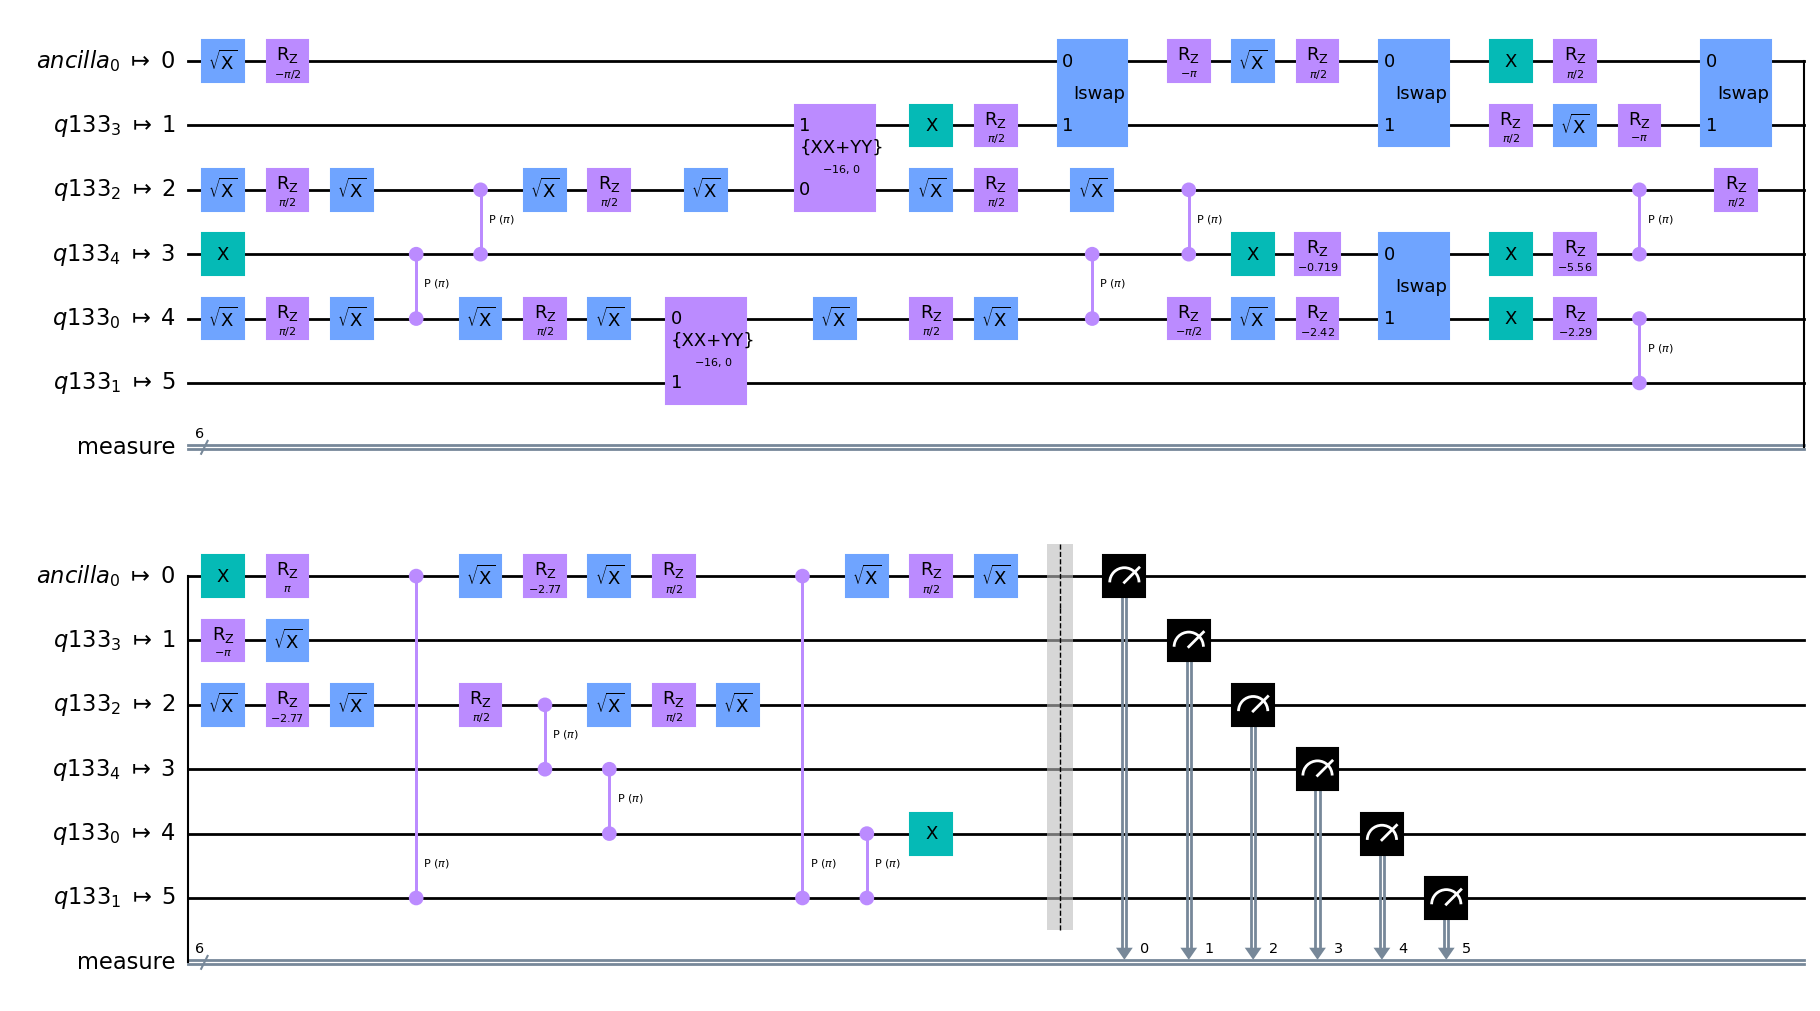

In [23]:
# Transpile to WMI hardware
test_circ = transpile(
    qc_trotter,
    backend=backend,
    optimization_level=3,
)
test_circ.measure_active()
test_circ.draw("mpl")

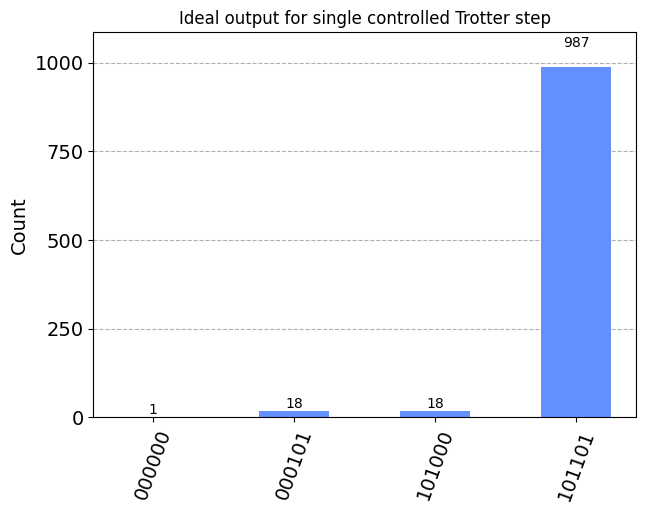

In [24]:
# Create ideal simulator backend and transpile circuit
sim_ideal = AerSimulator()
t_test_circ = transpile(test_circ, sim_ideal)

ideal_result = sim_ideal.run(t_test_circ).result()
ideal_counts = ideal_result.get_counts(0)
plot_histogram(ideal_counts,
               title='Ideal output for single controlled Trotter step')

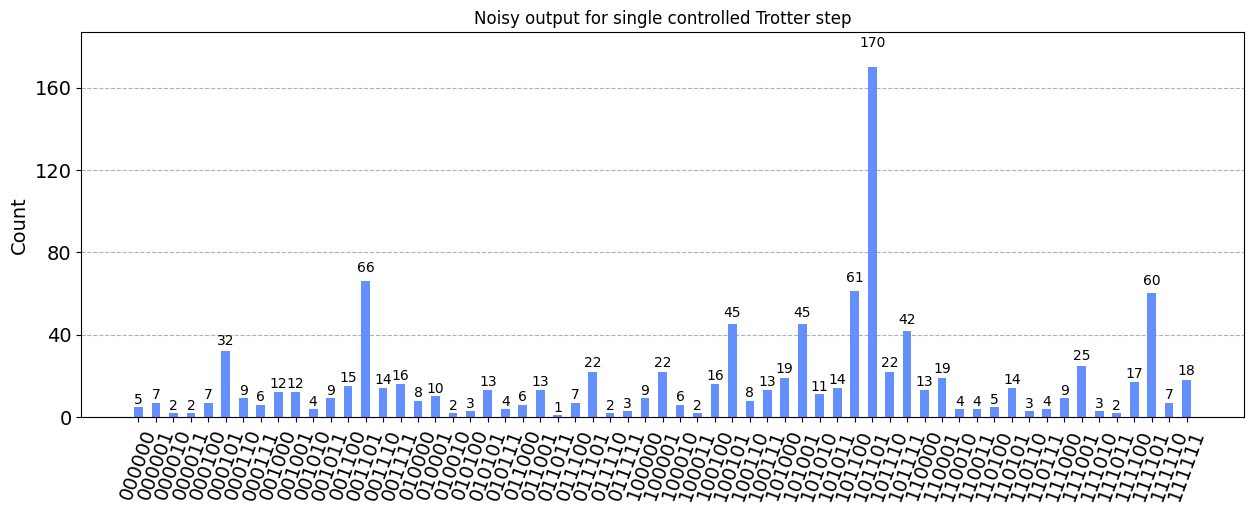

In [25]:
# Create noisy simulator and transpile circuit
wmi_backend = FakeWMI()
wmi_noise_model = NoiseModel.from_backend(wmi_backend)
wmi_noise_model.add_basis_gates(['unitary'])
sim_noise = AerSimulator(noise_model=wmi_noise_model)
test_circ = add_iswap_labels(test_circ)
test_circ = add_xx_plus_yy_labels(test_circ)
t_test_circ_noise = transpile(test_circ, sim_noise)

# Run on the simulator without noise
noise_result = sim_noise.run(t_test_circ_noise).result()
noise_counts = noise_result.get_counts(test_circ)
plot_histogram(noise_counts,
               title='Noisy output for single controlled Trotter step', figsize=(15,5))

In [26]:
def parity_check(noise_counts):
    filtered_noise_counts = {}
    for measurement, count in noise_counts.items():
        if (measurement.count('1') % 2 == 0):
            filtered_noise_counts[measurement] = str(count)
    return filtered_noise_counts

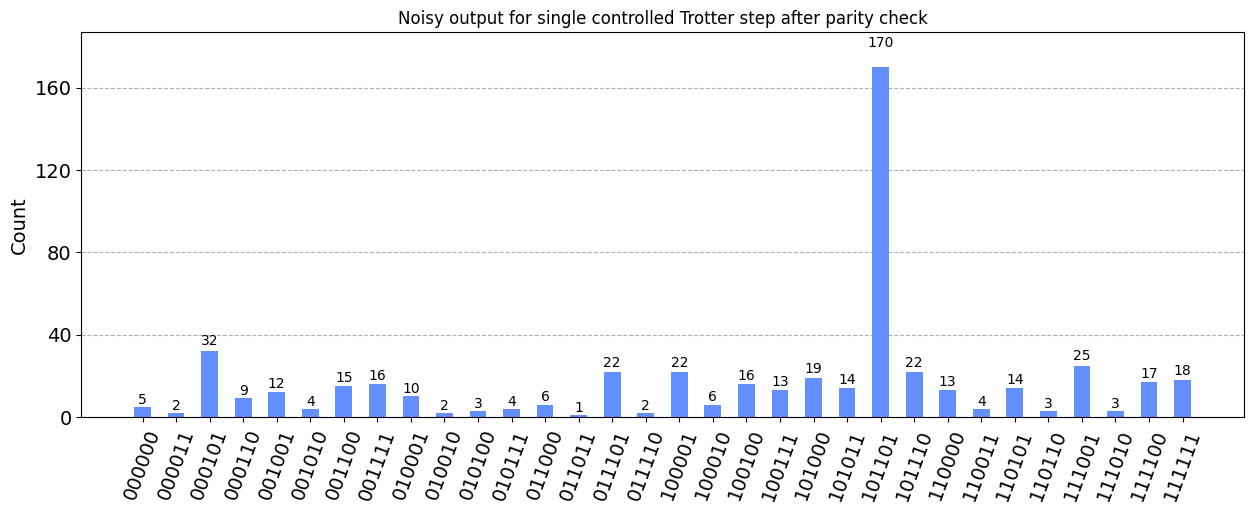

In [27]:
filtered_noise_counts = parity_check(noise_counts)
plot_histogram(filtered_noise_counts,
               title='Noisy output for single controlled Trotter step after parity check', figsize=(15,5))

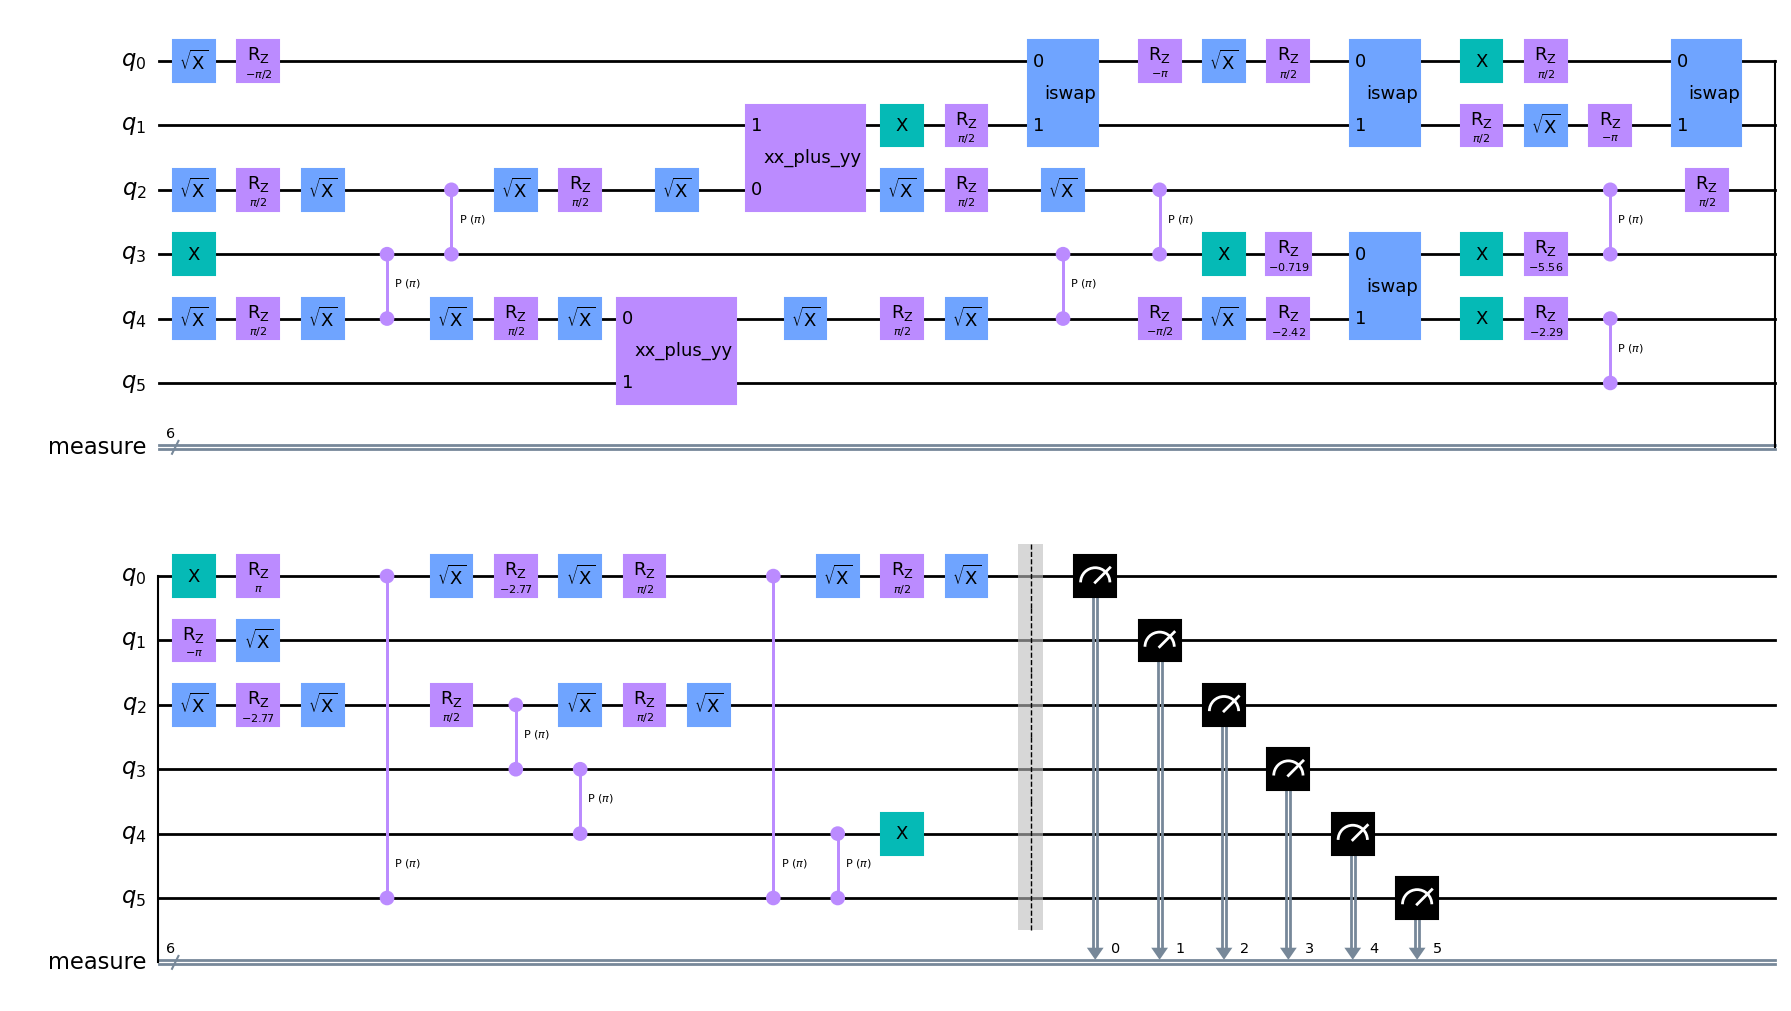

In [28]:
t_test_circ_noise.draw("mpl")

In [29]:
print(t_test_circ_noise.depth())

32


### QETU test

In [37]:
cheb_qsp_angles = [1.2121, -0.2663, 1.2121]
phi_vec = convert_Zrot_to_Xrot(cheb_qsp_angles)
U_qc = QETU(qc_trotter, convert_Zrot_to_Xrot(cheb_qsp_angles))

q = QuantumRegister(5)
U_qc = QuantumCircuit(q)
U_qc.rx(-2*phi_vec[0], 0)
for phi in phi_vec[1:]:
    U_qc.append(qc_trotter, [0,1,2,3,4])
    U_qc.rx(-2*phi, 0)

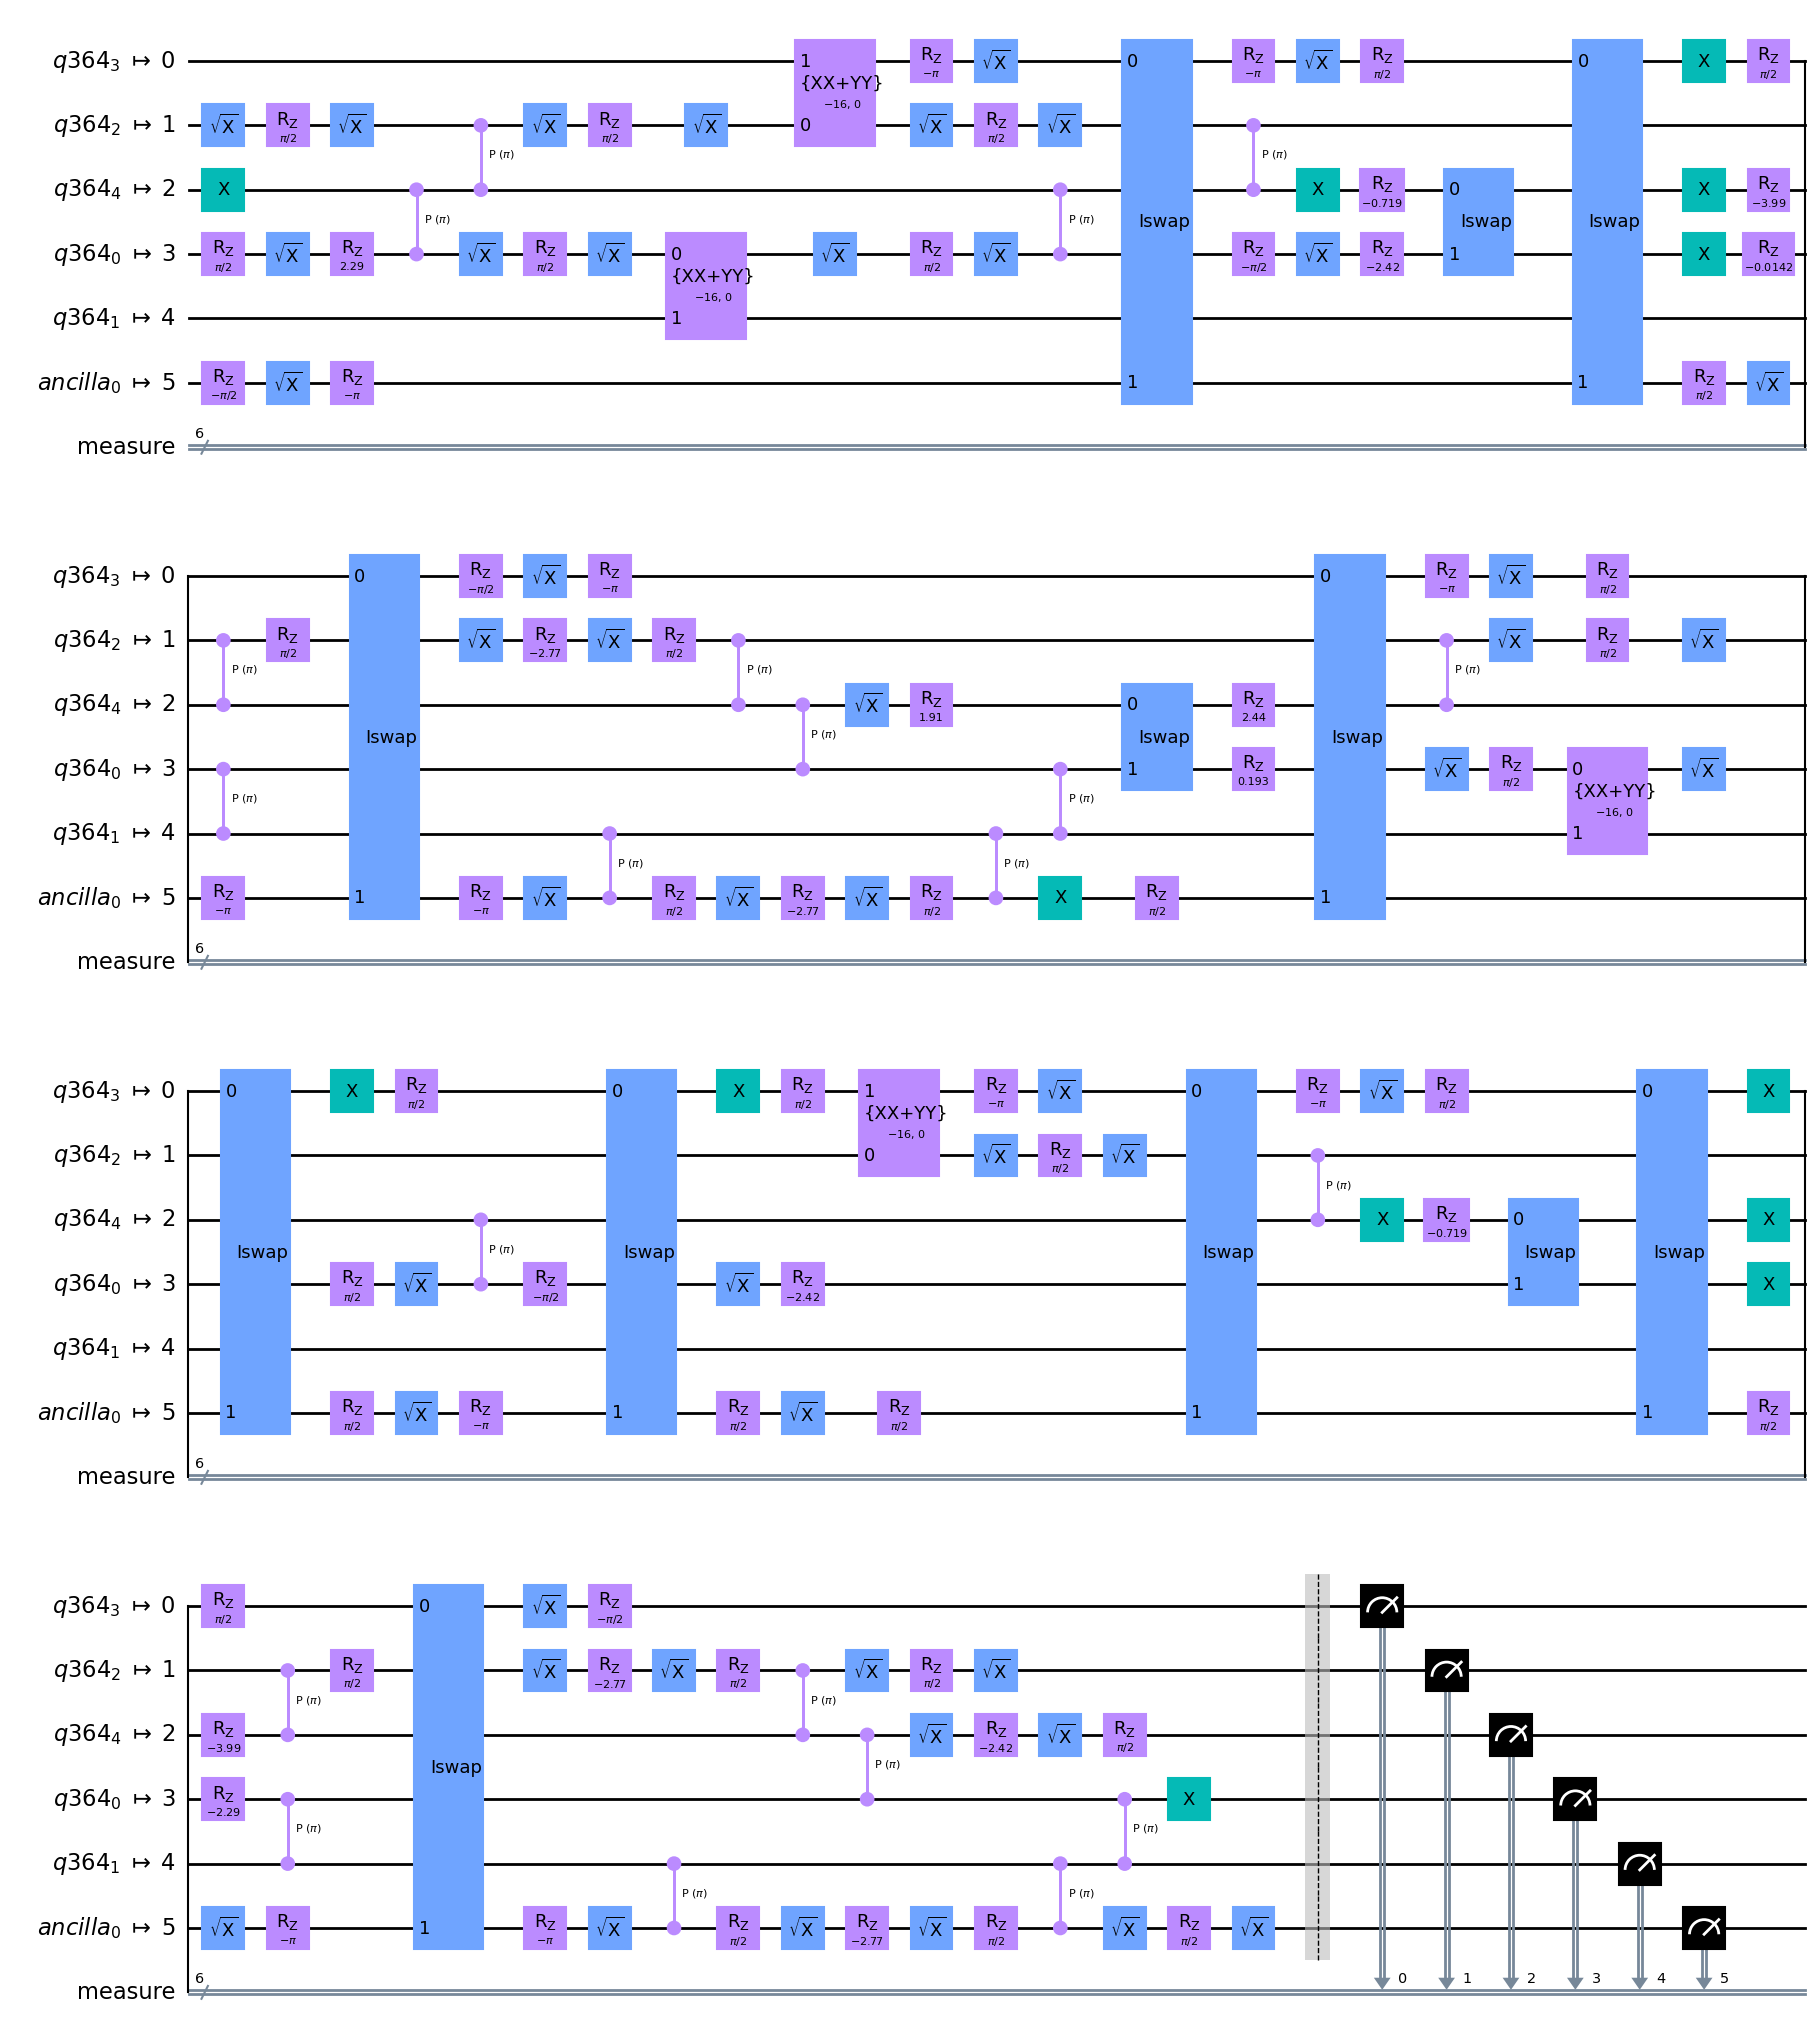

In [41]:
# Transpile to WMI hardware
test_circ = transpile(
    U_qc,
    backend=backend,
    optimization_level=3,
)
test_circ.measure_active()
test_circ.draw("mpl")

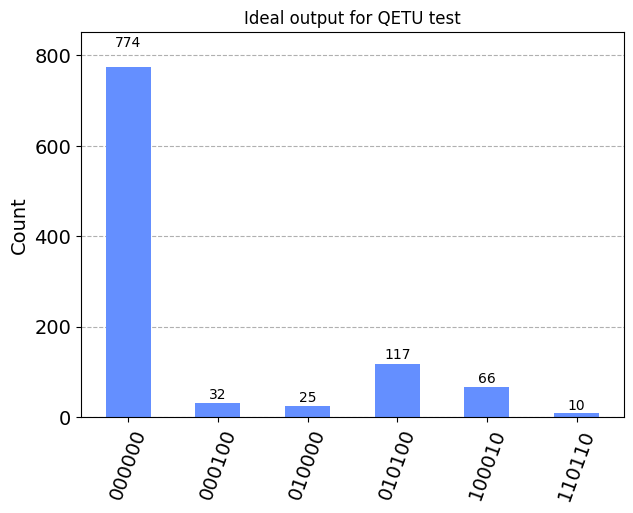

In [45]:
# Create ideal simulator backend and transpile circuit
sim_ideal = AerSimulator()
t_test_circ = transpile(test_circ, sim_ideal)

ideal_result = sim_ideal.run(t_test_circ).result()
ideal_counts = ideal_result.get_counts(0)
plot_histogram(ideal_counts,
               title='Ideal output for QETU test')

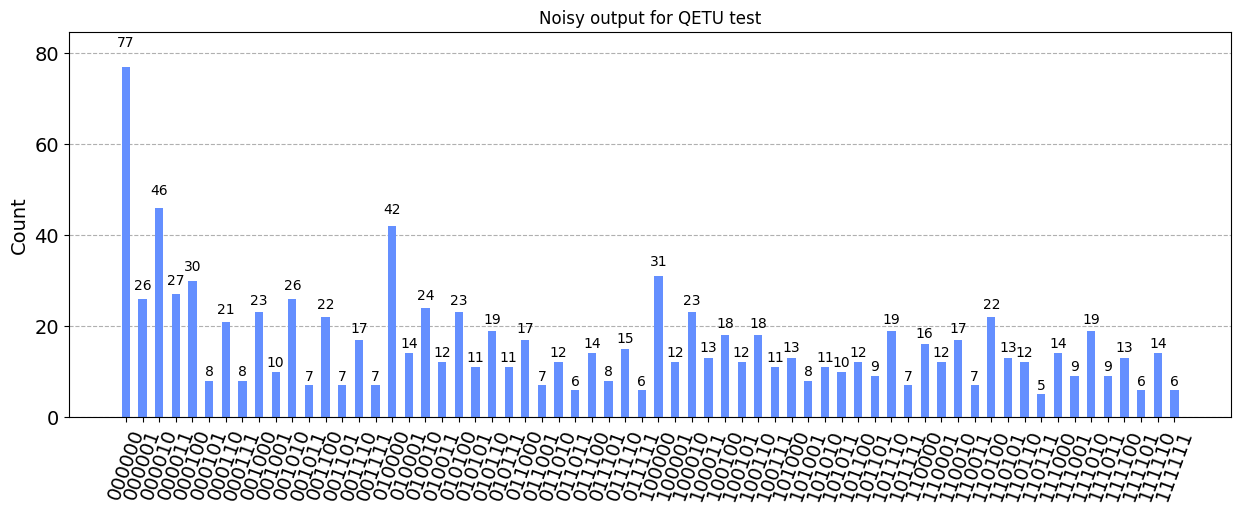

In [52]:
# Create noisy simulator and transpile circuit
wmi_backend = FakeWMI()
wmi_noise_model = NoiseModel.from_backend(wmi_backend)
wmi_noise_model.add_basis_gates(['unitary'])
sim_noise = AerSimulator(noise_model=wmi_noise_model)
test_circ = add_iswap_labels(test_circ)
test_circ = add_xx_plus_yy_labels(test_circ)
t_test_circ_noise = transpile(test_circ, sim_noise)

# Run on the simulator without noise
noise_result = sim_noise.run(t_test_circ_noise).result()
noise_counts = noise_result.get_counts(test_circ)
plot_histogram(noise_counts,
               title='Noisy output for QETU test', figsize=(15,5))

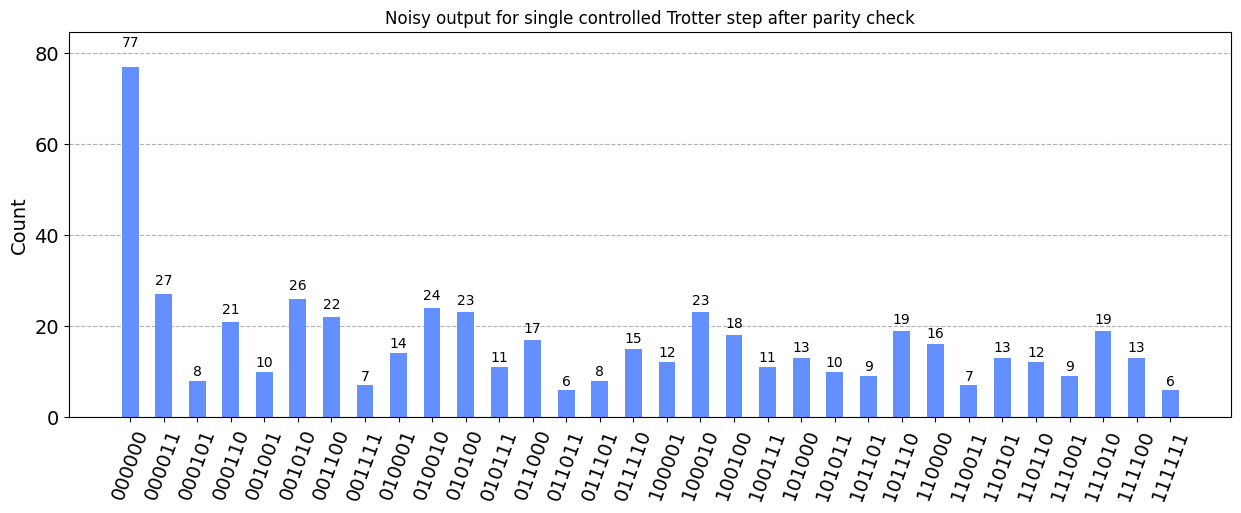

In [53]:
filtered_noise_counts = parity_check(noise_counts)
plot_histogram(filtered_noise_counts,
               title='Noisy output for single controlled Trotter step after parity check', figsize=(15,5))

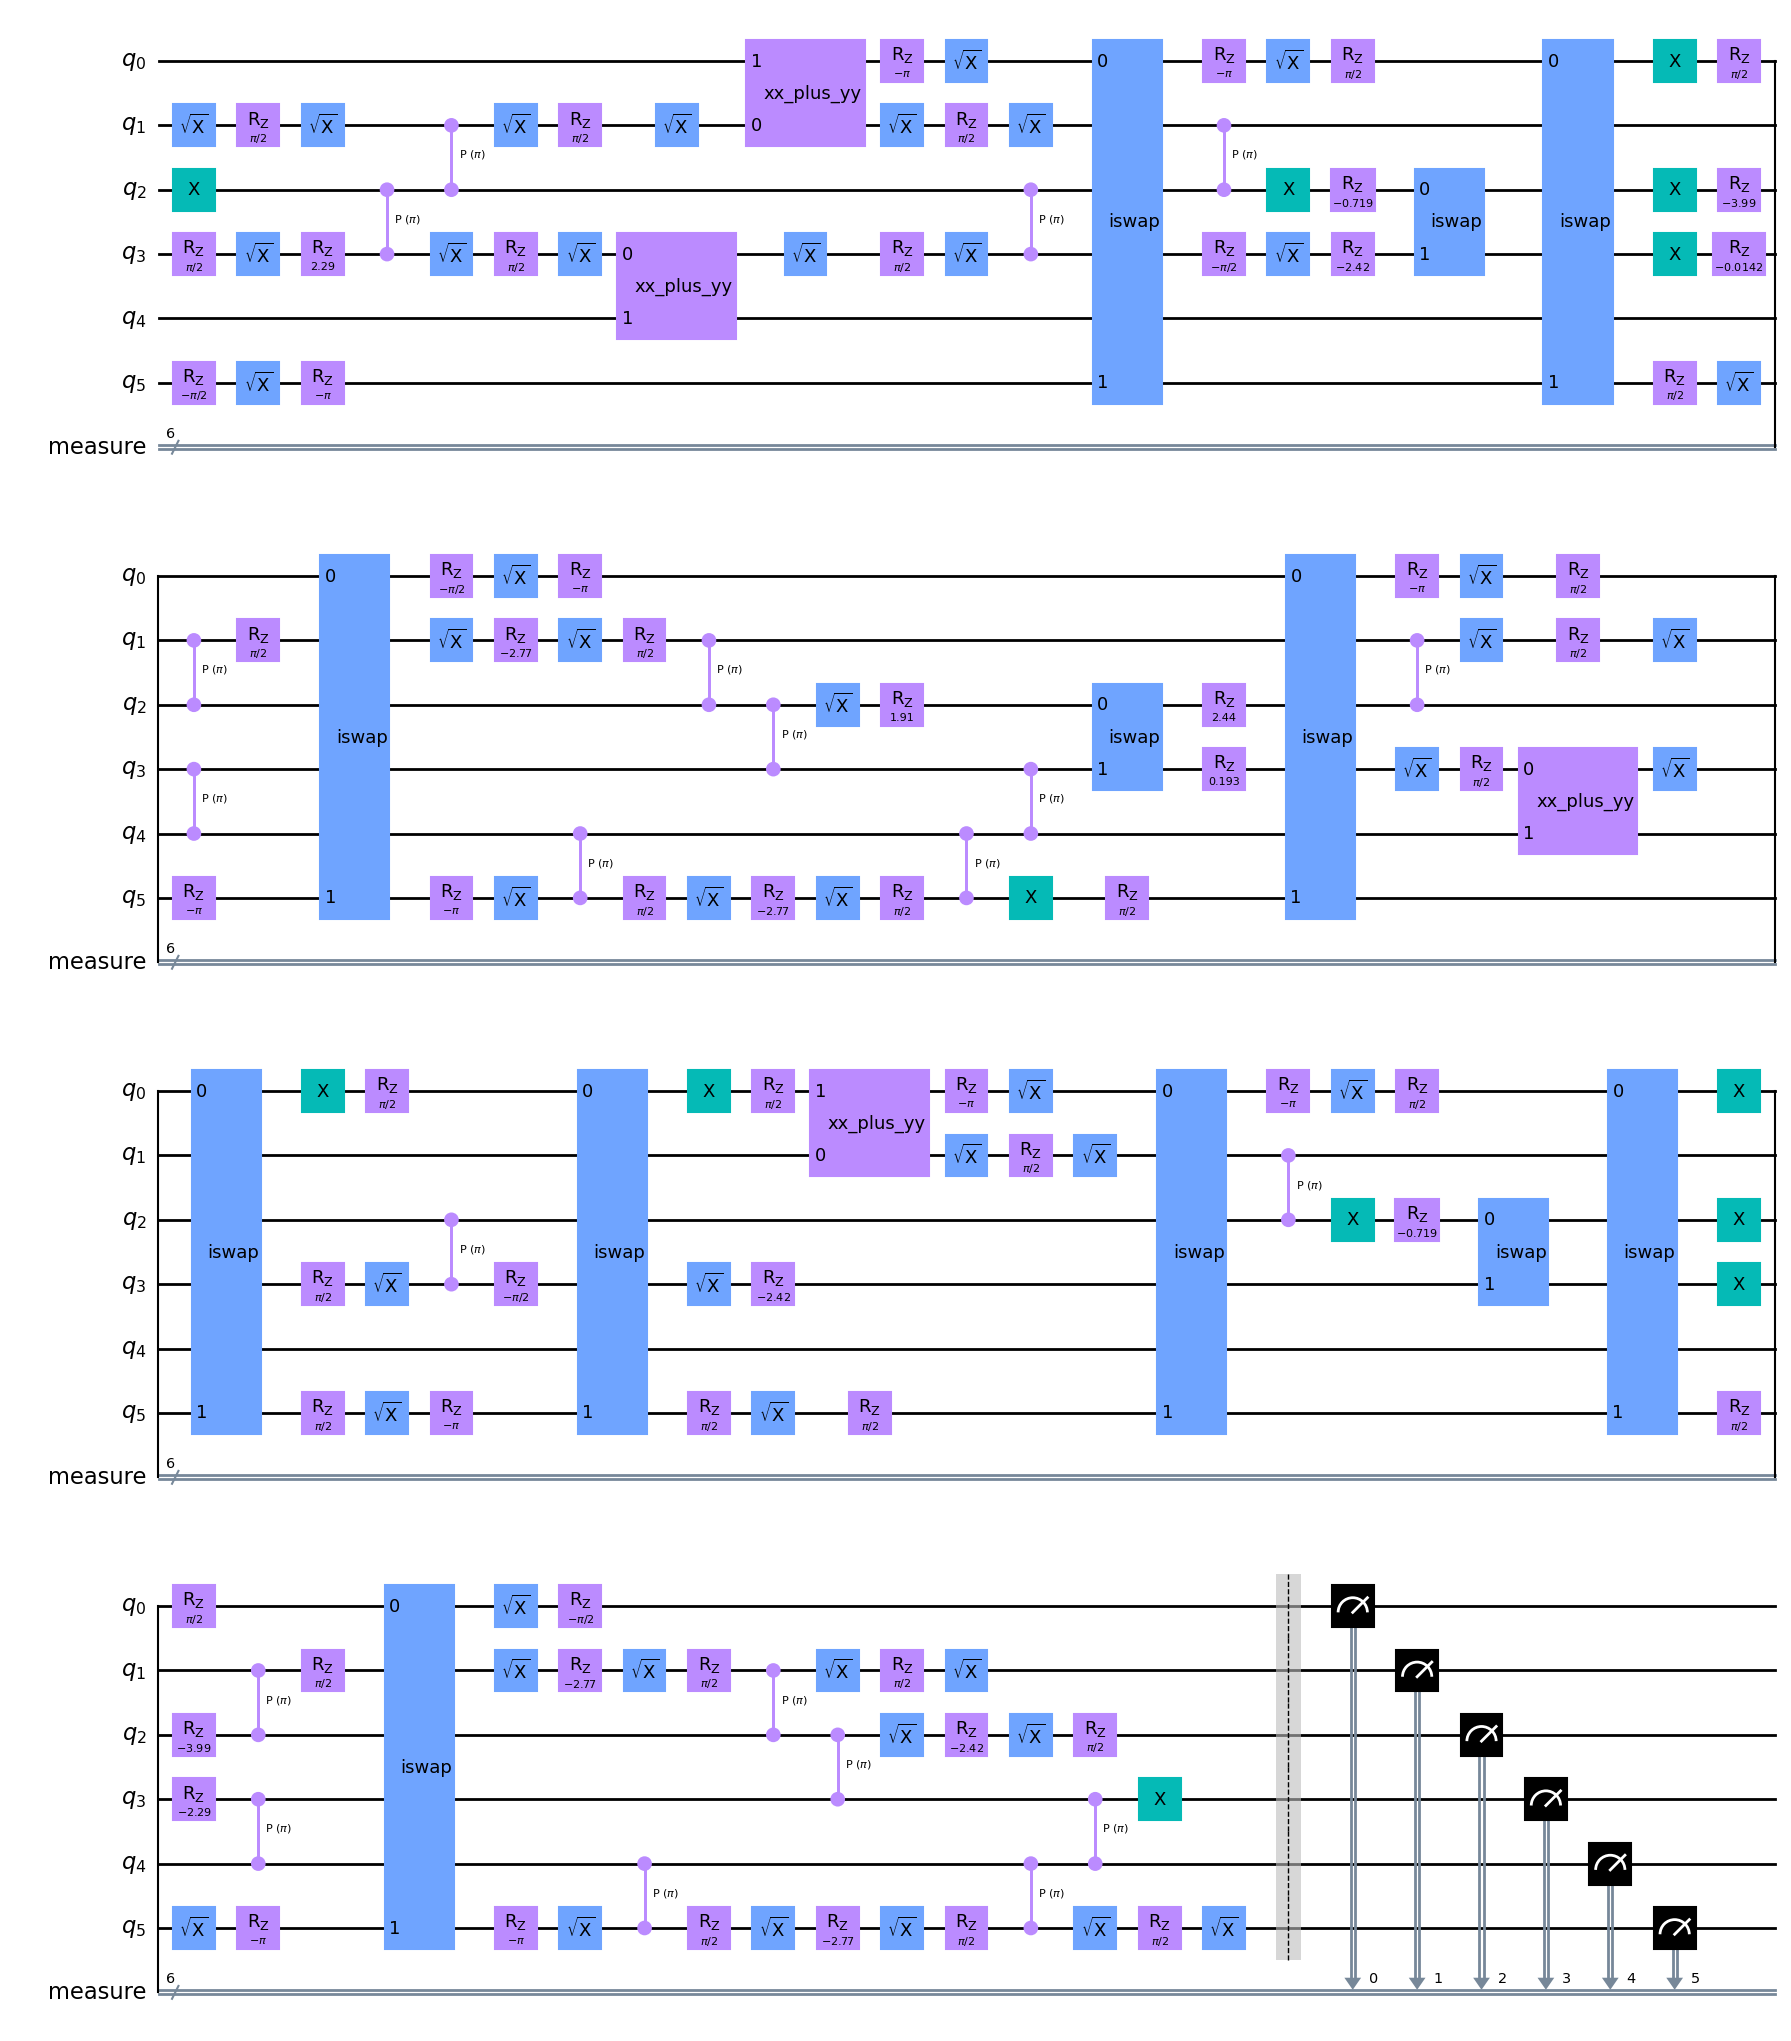

In [54]:
t_test_circ_noise.draw("mpl")

In [55]:
print(t_test_circ_noise.depth())

67
